In [107]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import random as random
from matplotlib.path import Path 
import numpy as np
import re

class DetroitDistrict:

    def __init__(self, data):
        self.Coordinates = self.extract_coordinates(data)
        self.Coordinates = self.Coordinates[0][0]
        self.HolcGrade = data['properties']['holc_grade']
        self.HolcColor = self.grade_to_color(self.HolcGrade)
        self.name = self.extract_name(data)  # Here we can define our extraction method
        self.QualitativeDescription = self.extract_section_8(data)
        self.RandomLat = None
        self.RandomLong = None
        self.MedianIncome = None
        self.CensusTract = None
        self.CountyCode = None
        self.BlackAndAfricanAmerican = None
    
    def extract_coordinates(self, data):
        # Extracting coordinates considering the fact that some districts can be non-contiguous
        return data['geometry']['coordinates']

    def grade_to_color(self, grade):
        color_map = {
            'A': 'darkgreen',
            'B': 'cornflowerblue',
            'C': 'gold',
            'D': 'maroon'
        }
        return color_map.get(grade, 'unknown') 

    def extract_name(self, data):
        # This is a placeholder. You can define the logic to extract the name or assign an iterator as required
        # For now, I'm returning the id of the district as its name
        return data['properties']['holc_id']

    def extract_section_8(self, data):
        return data['properties']["area_description_data"]['8']

  
def medianIncome(tract, county, data):
    for row in data:
        if row[3] == tract and row[2] == county:
            return row[0]
    return None


def mean_in(incomeList):
    if len(incomeList) != 0:
        sum = 0
        i = 0
        for n in incomeList:
            if n:
                sum += int(n)
                i += 1              
            else:
                pass
        return sum / i
    else:
        return "Not available now. Try again."

def median_in(incomeList):
    lst = []
    for n in incomeList:
        if n:
            lst.append(int(n))
    lst = sorted(lst)
    num = len(lst)
    if len(lst) != 0:
        if num % 2 == 1:
            return lst[((num+1)//2)]
        else:
            left = lst[(num//2 - 1)]
            right = lst[(num//2 + 1)]
        return (left + right) / 2
    else:
        return "Not available now. Try again."

def ten_Most_Common(strList):
    if len(strList) != 0:
        lst = []
        for word in strList:
            if word:
                lst.append(word)
        lst = " ".join(lst)
        words = re.findall(r'\b\w+\b', lst, re.IGNORECASE)
        words = [word.lower() for word in words] # convert to lower cases
        filler_words = ["the", "and", "of", "a", "is", "are", "in", "to", "for", "with", "but", "by", "this", "that",
                        "on", "at", "not", "as", "there", "very", "000", "all", "area", "2", "from"]
        most_10 = []
        common = {}
        for word in words:
            if word not in filler_words:
                if word not in common:
                    common[word] = 1
                else:
                    common[word] = common[word] + 1           
            
        #print(common)
        sorted_words = sorted(common.items(), key = lambda x: x[1], reverse = True)
        #print(sorted_words)
        for i in range(10):
            most_10.append(sorted_words[i][0])
        
        return most_10
    else:
        return "Not available now. Try again." 

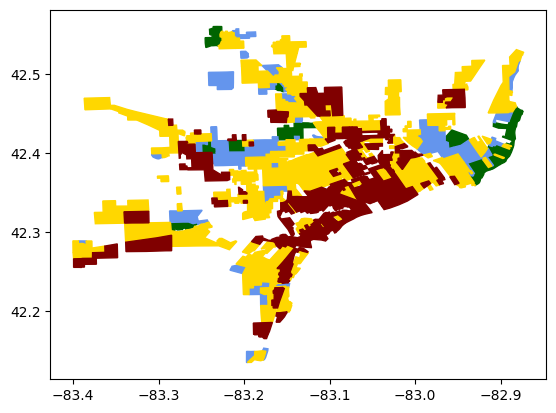

In [4]:
base_url = "https://dsl.richmond.edu/panorama/redlining/static/downloads/geojson/MIDetroit1939.geojson"
response = requests.get(base_url)

if response.status_code == 200:
    RedliningData = json.loads(response.text)
    # to access the features:
    features = RedliningData['features']    
else:
    print("Failed to fetch the GeoJSON data. Status code:", response.status_code)


Districts = [DetroitDistrict(feature) for feature in features]

fig, ax = plt.subplots()
for district in Districts: # what kind of for loop makes sense? 
    ax.add_patch(
    plt.Polygon(district.Coordinates, color =district.HolcColor,) 
    ) # add arguments here 
    ax.autoscale()
    plt.rcParams["figure.figsize"] = (15,15)
plt.show()


random.seed(17)
xgrid = np.arange(-83.5,-82.8,.004) 
ygrid = np.arange(42.1, 42.6, .004) 
xmesh, ymesh = np.meshgrid(xgrid,ygrid)
points = np.vstack((xmesh.flatten(),ymesh.flatten())).T


api_key = "84e5b35447fb5fd886aecc07d8325b7bb285eaf6"
data_cache = []


iii = 0
Alist = []
Blist = []
Clist = []
Dlist = []

AStringList = []
BStringList = []
CStringList = []
DStringList = []



In [112]:
for j in Districts:
        found = False
        for district in data_cache:
            if j.name == district.get("name"):
                found = True
                iii += 1
                p = Path(j.Coordinates, codes=None)
                grid = p.contains_points(points)
                point = points[random.choice(list(np.where(grid)[0]))] 
                j.RandomLong = point[0]
                j.RandomLat = point[1]
                j.CensusTract = district.get('CensusTract', None)
                j.MedianIncome = district.get('MedianIncome', None)
                j.BlackAndAfricanAmerican = district.get('BlackAndAfricanAmerican', None)
                print(f"{iii}, {j.name}-lat: {j.RandomLong}, long: {j.RandomLat}, code: {j.CensusTract}, income: {j.MedianIncome}\n")


                break
        if not found: 
            p = Path(j.Coordinates, codes=None)
            grid = p.contains_points(points)
            print(j," : ", points[random.choice(list(np.where(grid)[0]))]) 
            point = points[random.choice(list(np.where(grid)[0]))] 
            j.RandomLong = point[0]
            j.RandomLat = point[1]
            response = requests.get(f"https://geo.fcc.gov/api/census/block/find?latitude={j.RandomLat}&longitude={j.RandomLong}&format=json&showall=true")
            if response.status_code == 200:
                data = response.json()
                block_fips = data.get("Block", {}).get("FIPS", {})
                j.CensusTract = block_fips[5:11]
                j.CountyCode = block_fips[2:5]
                api_url = f"https://api.census.gov/data/2018/acs/acs5?key={api_key}&get=B19013_001E&for=tract:{j.CensusTract}&in=state:26+county:{j.CountyCode}"
                res = requests.get(api_url)
                if res.status_code == 200:
                    median_data = res.json()
                    j.MedianIncome = median_data[1][0] 
                else:
                    print(f"API request for {j.CensusTract} failed")
            else:
                print("API request failed")
        data_cache.append(vars(j))

    # Save the data cache as a JSON file
with open("income_data_cache.json", "w") as json_file:
    json.dump(data_cache, json_file, indent=2)
print("Data cache saved as income_data_cache.json")



743, A1-lat: -83.13999999999956, long: 42.435999999999815, code: 538200, income: 110870

744, A10-lat: -82.91199999999928, long: 42.39199999999984, code: 550500, income: 118661

745, A11-lat: -82.91199999999928, long: 42.40399999999983, code: 550700, income: 113220

746, A12-lat: -82.90799999999928, long: 42.39599999999984, code: 550600, income: 180455

747, A13-lat: -82.87999999999924, long: 42.44799999999981, code: 551100, income: 113611

748, A14-lat: -82.90399999999927, long: 42.435999999999815, code: 551100, income: 113611

749, A15-lat: -83.27599999999973, long: 42.307999999999886, code: 574800, income: 112768

750, A2-lat: -83.15599999999958, long: 42.419999999999824, code: 538600, income: 43613

751, A3-lat: -83.13199999999955, long: 42.43199999999982, code: 538400, income: 85882

752, A4-lat: -83.24799999999969, long: 42.40799999999983, code: 543400, income: 48250

753, A5-lat: -83.21599999999965, long: 42.41199999999983, code: 542100, income: 34979

754, A6-lat: -82.947999999

In [113]:

for district in data_cache:
    if district.get("HolcGrade") == "A":
        if type(district.get("MedianIncome")) == int:
            Alist.append(district.get("MedianIncome"))
            AStringList.append(district.get("QualitativeDescription"))
    elif district.get("HolcGrade") == "B":
        if type(district.get("MedianIncome")) == int:
            Blist.append(district.get("MedianIncome"))
            BStringList.append(district.get("QualitativeDescription"))
    elif district.get("HolcGrade") == "C":
        if type(district.get("MedianIncome")) == int:
            Clist.append(district.get("MedianIncome"))
            CStringList.append(district.get("QualitativeDescription"))
    elif district.get("HolcGrade") == "D":
        if type(district.get("MedianIncome")) == int:
            Dlist.append(district.get("MedianIncome"))
            DStringList.append(district.get("QualitativeDescription"))



In [114]:
A_mean_income = mean_in(Alist)
A_median_income = median_in(Alist)
print(f"A: mean income: {A_mean_income}, median income: {A_median_income}")

B_mean_income = mean_in(Blist)
B_median_income = median_in(Blist)
print(f"A: mean income: {B_mean_income}, median income: {B_median_income}")


C_mean_income = mean_in(Clist)
C_median_income = median_in(Clist)
print(f"C: mean income: {C_mean_income}, median income: {C_median_income}")

D_mean_income = mean_in(Dlist)
D_median_income = median_in(Dlist)
print(f"D: mean income: {D_mean_income}, median income: {D_median_income}")


A: mean income: 99367.55434782608, median income: 112768.0
A: mean income: 66304.45945945945, median income: 76439
C: mean income: 45169.71028037383, median income: 34321
D: mean income: 32990.041666666664, median income: 29516.0


In [111]:
 A_10_Most_Common = ten_Most_Common(AStringList)
print(f"A_10_Most_Common: {A_10_Most_Common}")
B_10_Most_Common = ten_Most_Common(BStringList)
print(f"B_10_Most_Common: {B_10_Most_Common}")
C_10_Most_Common = ten_Most_Common(CStringList)
print(f"C_10_Most_Common: {C_10_Most_Common}")
D_10_Most_Common = ten_Most_Common(DStringList)
print(f"D_10_Most_Common: {D_10_Most_Common}")
   


A_10_Most_Common: ['section', 'good', 'neighborhood', 'high', 'houses', 'detroit', 'class', 'development', 'well', 'city']
B_10_Most_Common: ['houses', 'good', 'streets', 'section', 'transportation', 'new', 'developed', 'singles', 'up', 'construction']
C_10_Most_Common: ['houses', 'flats', 'singles', 'see', 'explanation', 'sheet', 'grade', 'descriptions', '3rd', 'streets']
D_10_Most_Common: ['sheet', 'see', 'explanation', 'descriptions', 'flats', '4th', 'grade', 'houses', 'up', 'type']
